# Textons



纹理图像是由重复的规则或随机pattern构成的一类特殊图像。纹理描述了物体的材质。纹理基元（texton）是描述纹理的一种有效方式，是纹理图像的bag-of-visual-words模型。本次作业实现2D纹理图像中的LM texton，是[原文](https://people.eecs.berkeley.edu/~malik/papers/LM-3dtexton.pdf)算法的简化。

## 数据集

我们使用[Brodatz数据集](https://sipi.usc.edu/database/database.php?volume=textures)的一部分来做实验。该部分数据和本笔记本一起发布，下载使用即可。这些图像都是单通道1024分辨率。在做分类和重构实验中，可以截取512或者256大小的子图像作为训练集和测试集。

(tensor([[[0.4902, 0.4824, 0.4588,  ..., 0.5490, 0.5529, 0.5843],
         [0.4824, 0.4824, 0.4667,  ..., 0.5882, 0.5882, 0.5804],
         [0.4627, 0.4784, 0.4353,  ..., 0.5765, 0.5804, 0.6196],
         ...,
         [0.5255, 0.5569, 0.5020,  ..., 0.3647, 0.3569, 0.3922],
         [0.5529, 0.4941, 0.4510,  ..., 0.3647, 0.4392, 0.4471],
         [0.5176, 0.5020, 0.5059,  ..., 0.3765, 0.4196, 0.5176]]]), 0)
torch.Size([1, 256, 256])


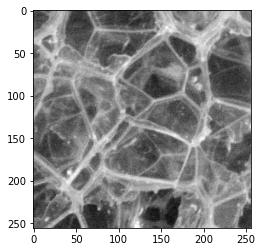

In [8]:
# 设计Brodatz数据集的Dataset类
# 使用1.3.01.tiff至1.3.13.tiff这13个纹理图像作为13个类别
# 但是在训练深度学习模型时，每类需要更多的图像，我们从每类中随机裁剪出100张256*256大小的子图像作为训练或者测试使用

import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image
import cv2 # 上面的read_image函数无法读取tiff图像

import os
import random

class BrodatzDataset(Dataset):
    def __init__(self, img_dir, num_per_class=100, transform=None):
        self.img_dir = img_dir
        self.num_per_class = num_per_class
        self.transform = transform
        self.img_files = [img_dir + '1.3.' + str(i).zfill(2) + '.tiff' for i in range(1, 14)]
        self.labels = []
        for img_file in self.img_files:
            label = os.path.basename(img_file).split('.')[0][-2:]
            self.labels.append(int(label)-1)
    
    def __len__(self):
        return self.num_per_class * 13
    
    def __getitem__(self, index):
        label = index // self.num_per_class
        # image = read_image(self.img_files[index]).float()
        image1024 = cv2.imread(self.img_files[index], -1)#.astype(np.float32)
        h, w = image1024.shape
        # image1024 = np.expand_dims(image1024, axis=0)
        x = random.randint(0, w - 256)
        y = random.randint(0, h - 256)
        image = image1024[y:y+256, x:x+256]        
        if self.transform:
            image = self.transform(image)        
        return image, label

training_dataset = BrodatzDataset(img_dir='./textures_2014/',
                  transform=torchvision.transforms.ToTensor())
a_sample = training_dataset[12]
print(a_sample)
print(a_sample[0].shape)  # the image, [C, H, W]

import matplotlib.pyplot as plt
plt.imshow(a_sample[0][0], cmap='gray')
plt.show()

In [77]:
199 // 100

1

## Texton

### LM filter bank

著名的牛津大学的VVG组提供了多种filter bank的[Matlab代码](https://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html)。网上有人做了[Python的实现](https://github.com/tonyjo/LM_filter_bank_python)。这份代码有bug，输出结果和Matlab的不一致，我把这个仓库fork了一份，并修正了其中的bug，稍后会给原作者提PR。本次作业请使用我修改后的[Python代码](https://github.com/qilin512/LM_filter_bank_python/blob/master/lm.py)（我只修改了lm.py文件）。

输出的F矩阵（3维数组）包含了48个滤波器，每个都是49*49。

In [54]:
# 使用我修改后的代码构造filter bank
# 可以把相关的代码拷贝过来，或者把该Python文件加入到工程中，作为jupyter笔记本调用的外部程序。

(49, 49, 48)


### 基于滤波器响应的纹理图像分类

使用filter bank对图像进行滤波，每个图像产生C个特征图（假设滤波器个数为C）。计算每个特征图的均值和方差，得到元素个数为2C的特征向量。使用KNN算法在特征向量的基础上对图像进行分类。scikit库里有个使用Garbor filters进行纹理分类的[例子](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html)，有一点相似的地方，可以参考。

In [ ]:
# 使用特征图的简单统计特征（均值和方差）对图像进行分类

### 生成textons

使用LM filter bank对纹理图像进行滤波，并生成Texton。具体地，针对一幅纹理图像（比如$H\times W$大小），使用filter bank进行滤波（滤波器个数为C），得到$H \times W \times C$的特征图。每个像素对应一个C维的特征向量。针对这$H \times W$个特征向量进行K-means聚类，设置聚类类别数K=20。这K个聚类中心即称为该纹理图像的Texton。这种算法是稀疏编码在纹理图像上的应用，对应着bag-of-words模型里的字典。

In [ ]:
# 你的实现代码

### 基于texton的纹理分类

如果做纹理分类任务，将数据集中的所有纹理图像都进行上述处理，每个图像都产生K个texton。所有图像的texton放在一起，再按距离把相似的texton进行合并（这一步可选），最终得到Q个texton。这样，每个图像的每个像素属于哪个texton是可追溯的，能得到一幅或者一类图像在这Q个textons上的频率分布（直方图）。在推断的时候，给定一幅纹理图像，滤波后，每个像素对应的特征向量和Q个texton计算距离，每个像素都会对应一个texton，从而获得该图像在Q个texton上的分布直方图。将该直方图和训练集中的每类对应的直方图计算卡方距离（$\chi^2$ distance），即能进行分类。

In [ ]:
# 分类任务

### 基于texton的纹理重建

输入：一幅纹理图像、按照上述方法对这幅图像构建的texton字典。

目标：利用texton重构该图像。

算法：

1. 计算滤波器矩阵的伪逆。将F矩阵里的每个滤波器都拉成一个向量，C个滤波器构成一个新的F矩阵（$HW \times C$），求这个矩阵的伪逆$F^+$。
2. 每个texton都与$F^+$相乘，得到每个texton对应的重构patch。根据原图像的每个像素值对应的texton，找到对应的重构patch，将该patch的中心元素作为重构图像的该像素的像素值。

In [ ]:
# 重构任务的代码

## 可学习的特征

filter bank设计得很巧妙，是学者的脑力贡献，如何运用filter bank提取的丰富特征？我们前面用过统计特征（均值和方差）和texton（聚类pooling）。如果能从数据中学习到参数，岂不是更好？最后让我们借鉴深度学习里的CNN（convolutional neural network）。

请设计一个两层的CNN网络，第一个卷积层设置为我们的filter bank：48个卷积核（滤波器），大小为$49 \times 49$（够大核的）。第二层卷积层的卷积核个数为类别数，大小为$1 \times 1$。网络的第三层为global average pooling层(GAP层)。最后接softmax输出类别概率。

第一层卷积层因为使用设计好的filter bank，所以需要加载现成的参数，相当于预训练的部分模型参数。

实验分两部分。第一部分实验freeze第一个卷积层，只学习第二个卷积层。第二部分实验学习网络的全部参数，相当于对filter bank进行微调fine tuning。对比一下两个部分的分类效果，并把第二部分的微调后的第一个卷积层的滤波器保存并可视化出来，看看和学者们设计的滤波器相比有什么变化。

In [ ]:
# 华为智能基座吗？
# import mindspore as torch

# 下面这个示例是关于如何修改网络参数以及固定网络参数不更新

import numpy as np
import torch
from torch import nn

class TextonNet(nn.Module):
    def __init__(self):
        super(TextonNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1, bias=False)
        self.fc1 = nn.Linear(2, 3)
    def forward(self, x):
        out = self.conv1(x)
        out = self.fc1(out)
        return out

model = TextonNet()
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

# 修改模型的某个参数，参考这个实现加载LM filter bank
with torch.no_grad():
    # 修改全连接层矩阵里的某个元素的值
    model.fc1.weight[0][0] = 99
    # 修改卷积层里的两个滤波器为Sobel算子
    model.conv1.weight[0][0] = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    model.conv1.weight[1][0] = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")


### 冻结模型参数

In [6]:
# 获取模型的参数，有state_dict和parameters（named_parameters)两种方法，
# 除了返回类型不同外，更重要的是参数的requires_grad属性的区别。
# 尤其是需要把某些参数freeze，使其不在学习过程中更新


# 方法1：直接修改参数的"requires_grad"值
model.fc1.weight.requires_grad = False

# 方法2：通过parameters()或named_parameter()函数返回的生成器(generator)来修改
for name, param in model.named_parameters():
    if name == 'conv1.weight':
        param.requires_grad = False

for name, param in model.named_parameters():
    print(f'{name}, {param.requires_grad}')
print('\n')

# 如何验证修改成功了呢？
# 这时需要使用parameters()或者named_parameters()函数提取参数，然后输出其requires_grad属性查看。
# 因为模型训练时，是把模型的parameters()传给优化器，而不是state_dict。

# 错误的方法：通过state_dict来修改
# 这种做法无法在反向传播时冻结参数
# state_dict提取的模型参数的requires_grad默认都是False
# 比如直接输出fc1.bias的requires_grad属性，结果为False
print("state_dict['fc1.bias'].requires_grad is ")
print(model.state_dict()['fc1.bias'].requires_grad)

# 下面的代码，使用state_dict将fc1.bias的requires_grad修改为False，
# 通过state_dict的方式再次验证，其值也是False，
# 但是通过named_parameters()方法查看其requires_grad属性，结果还是True
model.state_dict()['fc1.bias'] = False
print("state_dict['fc1.bias'].requires_grad is ")
print(model.state_dict()['fc1.bias'].requires_grad)
for name, param in model.named_parameters():
    print(f'{name}, {param.requires_grad}')
print('\n')
# PyTorch这样设计是因为考虑到使用state_dict提取模型参数时通常会做一些修改，
# 如果这些修改使用了某些影响梯度跟踪的运算，当requires_grad默认是True时会影响该参数的梯度计算。

# 网上有人提到用下面这种方法也是错误的。
tmp_state_dict = model.state_dict()
tmp_state_dict['fc1.bias'].requires_grad = False
model.load_state_dict(tmp_state_dict)
for name, param in model.named_parameters():
    print(f'{name}, {param.requires_grad}')
print('\n')

conv1.weight, False
fc1.weight, False
fc1.bias, True


state_dict['fc1.bias'].requires_grad is 
False
state_dict['fc1.bias'].requires_grad is 
False
conv1.weight, False
fc1.weight, False
fc1.bias, True


conv1.weight, False
fc1.weight, False
fc1.bias, True




如果微调后的滤波器分类效果更好的话，可否用在重构任务上？重构的效果会不会更好？如果重构效果更好的话，可否用深度网络实现重构任务？